## Collocation Using Julia Packages

We will use the CompEcon toolbox to approximate several simple functions in order to learn how to use the packages.

1. f(x) = sqrt(x)
2. f(x) = exp(x)
3. f(x) = sin(x)

In [67]:
# Packages for collocation and for plotting
using CompEcon
using PyPlot
using Roots
using Optim

# Upper bound of approximation domain
upper_bound = 2.*pi

# Lower bound of approximation domain
lower_bound = 0.

# Number of collocation nodes, or one plus the degree of the approximation
num_nodes = 3

# Function space fundefn(basis type, number of collocation nodes, lower bound of domain, upper bound of domain)
space = fundefn(:cheb,num_nodes,lower_bound,upper_bound)

# Collocation grid
s, bounds = funnode(space)

# Preinvert polynomial matrix for computing coefficients: Bc = y, c = B\y
Binv = funbase(space,s)\eye(num_nodes,num_nodes)

3×3 Array{Float64,2}:
  0.333333   0.333333    0.333333
 -0.57735   -5.1279e-16  0.57735 
  0.333333  -0.666667    0.333333

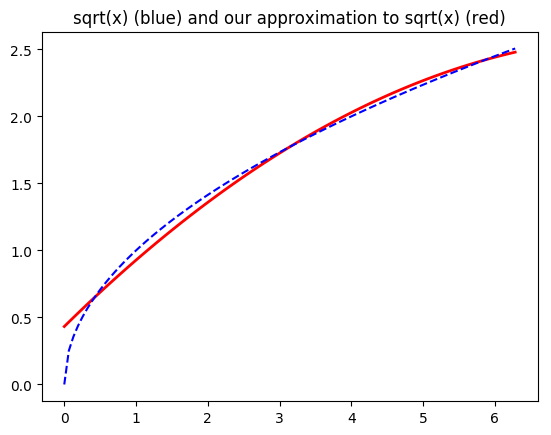

PyObject <matplotlib.text.Text object at 0x7f7c87c28b50>

In [68]:
# Function to approximate
ff1(x) = sqrt(x)

# True function values on the grid, s
true_values1 = ff1(s)

coeffs1 = Binv*true_values1

# Initialize consumption array
f1 = zeros(100)

# Put a fine grid over the capital domain
x1 = linspace(lower_bound,upper_bound,100)

# True function values on the grid
true_values_plot1 = ff1(x1) 

# Compute optimal consumption at all capital grid points
for i = 1:100
    f1_out, f1_eval = funeval(coeffs1,space,[x1[i]])
    f1[i] = f1_out[1]
end

# Plot policy function
plot(x1, f1, color="red", linewidth=2.0)
plot(x1, true_values_plot1, color="blue", linewidth=1.5, linestyle="--")
title("sqrt(x) (blue) and our approximation to sqrt(x) (red)")

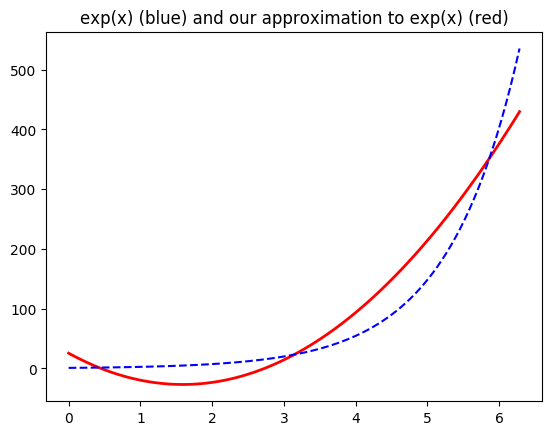

PyObject <matplotlib.text.Text object at 0x7f7c875d7e90>

In [69]:
# Function to approximate
ff2(x) = exp(x)

# True function values on the grid, s
true_values2 = ff2(s)

coeffs2 = Binv*true_values2

# Initialize consumption array
f2 = zeros(100)

# Put a fine grid over the capital domain
x2 = linspace(lower_bound,upper_bound,100)

# True function values on the grid
true_values_plot2 = ff2(x2)

# Compute optimal consumption at all capital grid points
for i = 1:100
    f2_out, f2_eval = funeval(coeffs2,space,[x2[i]])
    f2[i] = f2_out[1]
end

# Plot policy function
plot(x2, f2, color="red", linewidth=2.0)
plot(x2, true_values_plot2, color="blue", linewidth=1.5, linestyle="--")
title("exp(x) (blue) and our approximation to exp(x) (red)")

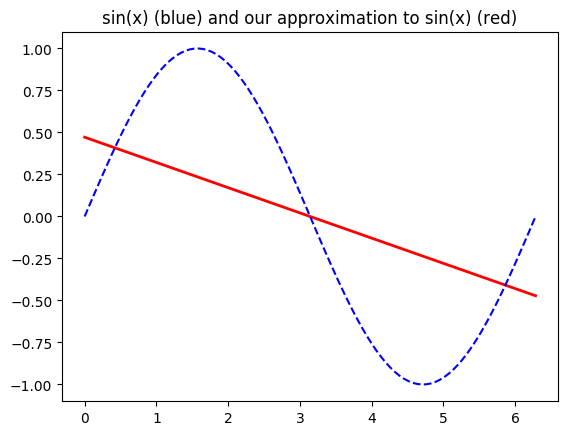

PyObject <matplotlib.text.Text object at 0x7f7c874c7d50>

In [70]:
# Function to approximate
ff3(x) = sin(x)

# True function values on the grid, s
true_values3 = ff3(s)

coeffs3 = Binv*true_values3

# Initialize consumption array
f3 = zeros(100)

# Put a fine grid over the capital domain
x3 = linspace(lower_bound,upper_bound,100)

# True function values on the grid
true_values_plot3 = ff3(x3)

# Compute optimal consumption at all capital grid points
for i = 1:100
    f3_out, f3_eval = funeval(coeffs3,space,[x3[i]])
    f3[i] = f3_out[1]
end

# Plot policy function
plot(x3, f3, color="red", linewidth=2.0)
plot(x3, true_values_plot3, color="blue", linewidth=1.5, linestyle="--")
title("sin(x) (blue) and our approximation to sin(x) (red)")

## Three Algorithms for Computing Dynamic Models

Here we will solve the basic infinite horizon growth model. The representative consumer has CRRA utility, $u(c_t) = c_t^{1-\gamma}/(1-\gamma)$ and she discounts the future at a rate $\beta$. Her production function is solely a function of capital $F(k_t) = k_t^\alpha$, and capital fully depreciates so that $k_{t+1} = F(k_t) - c_t.$

Solve this model with three methods:
1. Value function iteration
2. Fixed point iteration
3. Time iteration

For fixed point iteration, solve for the Euler equation and then put it in fixed point form. Then approximate the optimal policy function, $c_t = C(k_t)$ by iterating on the transformed Euler equation.

For time iteration, solve a root-finding problem on the Euler equation.

Parameter values for the model are:
- $\alpha = 0.75$
- $\beta = 0.95$
- $\gamma = 2$

Use between $5-10$ collocation nodes and a damping parameter of $0.7$ (only 70% weight on the new coefficient update) for a stable solution.

### Value Function Iteration

In [71]:
# Model parameters
gamma = 2. # RIA
alpha = 0.75 # Capital share
beta = 0.95 # Discount factor
damp = 0.7 # Damping
tol = 1e-4 # Tolerance
error = 1e10 # Initial error

# Steady state capital
steady_capital = (alpha*beta)^(1/(1-alpha))

# Upper bound of approximation domain
upper_bound = 1.5.*steady_capital

# Lower bound of approximation domain
lower_bound = 0.5*steady_capital

# Number of collocation nodes
num_nodes = 4

# Function space
space = fundefn(:cheb,num_nodes,lower_bound,upper_bound)

# Collocation grid
s, bounds = funnode(space)

# Number of collocation nodes
space[:num_nodes] = num_nodes

# Initial coefficient vector
space[:c] = .1*ones(space[:num_nodes])

# Preinvert polynomial matrix for computing coefficients
Binv = funbase(space,s)\eye(space[:num_nodes],space[:num_nodes])

4×4 Array{Float64,2}:
  0.25       0.25       0.25      0.25    
 -0.46194   -0.191342   0.191342  0.46194 
  0.353553  -0.353553  -0.353553  0.353553
 -0.191342   0.46194   -0.46194   0.191342

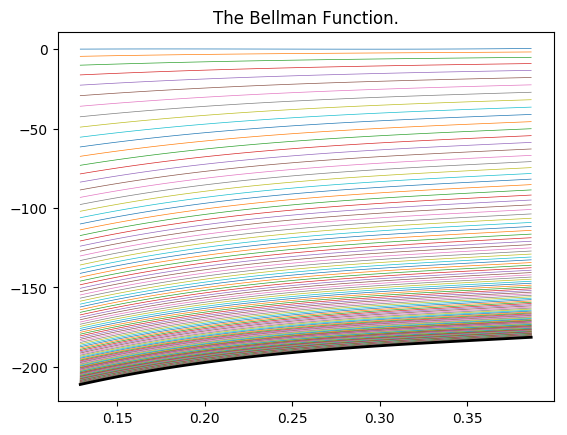

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7c870b05d0>

In [72]:
## VALUE FUNCTION ITERATION

# Initialize value array
value = -.0*ones(space[:num_nodes])

# Initial error
error = 1e10 

while error > tol
    
    # Initialize consumption array
    c = zeros(100)

    # Put a fine grid over the capital domain
    capital_levels = linspace(lower_bound,upper_bound,100)

    # Compute optimal consumption at all capital grid points
    for t = 1:100
        c_out, c_eval = funeval(space[:c],space,[capital_levels[t]])
        c[t] = c_out[1]
    end

    # Plot policy function
    plot(capital_levels, c, linewidth=0.5)
    
    title("The Bellman Function.")
    
    # Compute next period's consumption from the Euler equation
    for i = 1:space[:num_nodes]
        
        # Initialize difference
        d = 1e10
        
        capital = s[i]

        # Bellman equation
        # V(k_t) = max_{c_t} u(c_t) + beta V(k_{t+1})
        function bellman(consi::Float64)
        
            # Next period's capital given current capital and consumption
            capital_next = capital^alpha-consi
        
            # Continuation given current capital and consumption
            cont_value, eval = funeval(space[:c],space,[capital_next])
        
            # Total payoff
            if gamma == 1.
                value = log(consi) + beta*cont_value
            else
                value = (consi)^(1-gamma)/(1-gamma) + beta*cont_value
            end
            return -value[1]
            
        end
        
        results = optimize(bellman, 0.25*capital^alpha, 0.99*capital^alpha)
        
        # Compute new value
        value[i] = -Optim.minimum(results)
    end
    
    # New coefficients on approximant, damp the update
    c_next = damp*(Binv*value) + (1-damp)*space[:c]

    # Relative change in coefficients at collocation nodes
    error = maximum(abs.((Binv*value-space[:c])./(Binv*value)))

    # Update coefficients
    space[:c] = c_next

    # Display error
    #println("Maximum Error of $(error).")
    

end

# Initialize consumption array
c = zeros(100)

# Put a fine grid over the capital domain
capital_levels = linspace(lower_bound,upper_bound,100)

# Compute optimal consumption at all capital grid points
for t = 1:100
    c_out, c_eval = funeval(space[:c],space,[capital_levels[t]])
    c[t] = c_out[1]
end

# Plot policy function
plot(capital_levels, c, linewidth=2.0, color="black")

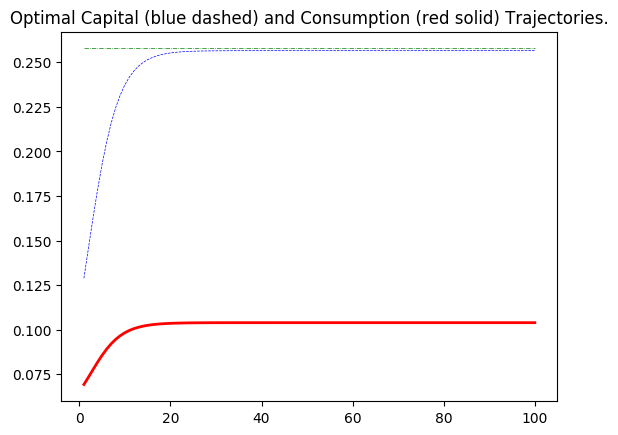

Validate the solution: Does the final capital value of 0.2564857851185086 arrive at the analytically derived capital steady state of 0.2577148681640624?


In [73]:
# Simulate using solved Bellman function

# Horizon of simulation
horizon = 100

# Initialize capital and consumption vectors
k = zeros(horizon+1)
c = zeros(horizon)

# Initial capital value
k[1] = steady_capital/2

# Simulate
for t = 1:horizon

    capital = k[t]
    
    # Bellman equation
    # V(k_t) = max_{c_t} u(c_t) + beta V(k_{t+1})
    function bellman(consi::Float64)
    
        # Next period's capital given current capital and consumption
        capital_next = capital^alpha-consi
    
        # Continuation given current capital and consumption
        cont_value, eval = funeval(space[:c],space,[capital_next])
    
        # Total payoff
        if gamma == 1.
            value = log(consi) + beta*cont_value
        else
            value = (consi)^(1-gamma)/(1-gamma) + beta*cont_value
        end
        
        return -value[1]
        
    end
    
    results = optimize(bellman, 0., capital^alpha)
    
    # Compute new value
    c[t] = Optim.minimizer(results)
    k[t+1] = capital^alpha-c[t]
end

# Plot
plot(1:horizon, c, color="red", linewidth=2.0)
plot(1:horizon, k[1:end-1], color="blue", linewidth=0.5, linestyle="--")
plot(1:horizon, steady_capital*ones(horizon), color="green", linewidth=0.5, linestyle="-.")
title("Optimal Capital (blue dashed) and Consumption (red solid) Trajectories.")
println("Validate the solution: Does the final capital value of $(k[end]) arrive at the analytically derived capital steady state of $(steady_capital)?")

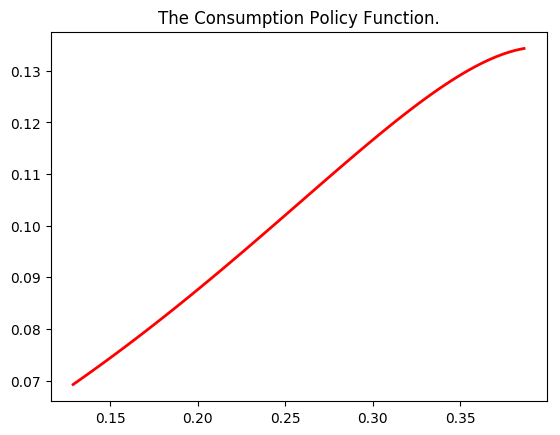

PyObject <matplotlib.text.Text object at 0x7f7c870520d0>

In [74]:
# Plot optimal policy function

# Initialize consumption array
c = zeros(horizon)

# Put a fine grid over the capital domain
capital_levels = linspace(lower_bound,upper_bound,100)

# Compute optimal consumption at all capital grid points
for t = 1:100

    capital = capital_levels[t]

    # Bellman equation
    # V(k_t) = max_{c_t} u(c_t) + beta V(k_{t+1})
    function bellman(consi::Float64)

        # Next period's capital given current capital and consumption
        capital_next = capital^alpha-consi

        # Continuation given current capital and consumption
        cont_value, eval = funeval(space[:c],space,[capital_next])

        # Total payoff
        if gamma == 1.
            value = log(consi) + beta*cont_value
        else
            value = (consi)^(1-gamma)/(1-gamma) + beta*cont_value
        end

        return -value[1]

    end

    results = optimize(bellman, 0., capital^alpha)

    # Compute new value
    c[t] = Optim.minimizer(results)
end

# Plot policy function
plot(capital_levels, c, color="red", linewidth=2.0)
title("The Consumption Policy Function.")

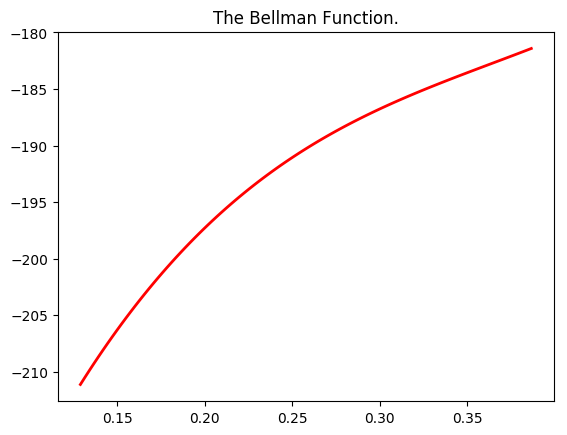

PyObject <matplotlib.text.Text object at 0x7f7c86f84e90>

In [75]:
# Initialize consumption array
c = zeros(horizon)

# Put a fine grid over the capital domain
capital_levels = linspace(lower_bound,upper_bound,100)

# Compute Bellman at all capital grid points
for t = 1:100
    c_out, c_eval = funeval(space[:c],space,[capital_levels[t]])
    c[t] = c_out[1]
end

# Plot policy function
plot(capital_levels, c, color="red", linewidth=2.0)
title("The Bellman Function.")

### Fixed Point Iteration

In [76]:
# Model parameters, only changes to FPI from VFI
damp = 0.7 # Damping
tol = 1e-4 # Tolerance
error = 1e10 # Initial error

1.0e10

In [77]:
# Fixed point Euler equation

# c_t = u'^(-1)(beta*u'(c_t+1)*F'(k_t+1))
# k_t+1 = F(k_t) - c_t
function consumption_euler(capital::Float64,space::Dict{Symbol,Any})

    # Current consumption given current capital
    cons, eval = funeval(space[:c],space,[capital])

    # Next period's capital given current capital and consumption
    capital_next = capital^alpha-cons

    # Next period's consumption given current capital and consumption
    cons_next, eval = funeval(space[:c],space,capital_next)
    cons_next = max(1e-10,cons_next)
    
    # Next period's consumption from Euler equation
    cons_next = (beta*cons_next^(-gamma)*alpha*(capital_next).^(alpha-1)).^(-1/gamma)
    return cons_next[1]
end

consumption_euler (generic function with 1 method)

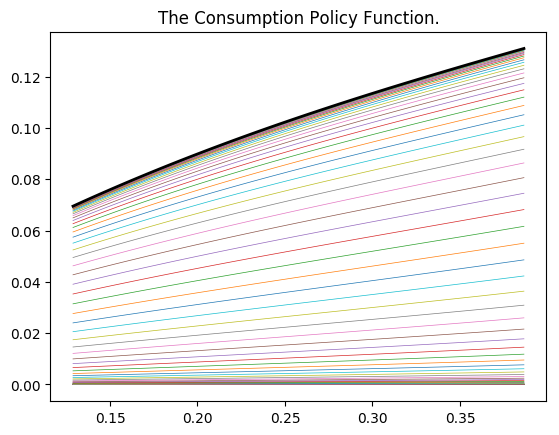

PyObject <matplotlib.text.Text object at 0x7f7c86f1d290>

In [78]:
## FIXED POINT ITERATION

# Initial coefficient vector
space[:c] = .0*ones(space[:num_nodes])

# Initialize consumption array
cons_next = Array{Float64}(space[:num_nodes])

while error > tol
    
    # Plot optimal policy function

    # Initialize consumption array
    c = zeros(100)

    # Put a fine grid over the capital domain
    capital_levels = linspace(lower_bound,upper_bound,100)

    # Compute optimal consumption at all capital grid points
    for t = 1:100
        c_out, c_eval = funeval(space[:c],space,[capital_levels[t]])
        c[t] = c_out[1]
    end

    # Plot policy function
    plot(capital_levels, c, linewidth=0.5)
    title("The Consumption Policy Function.")
    
    # Compute next period's consumption from the Euler equation
    for i = 1:space[:num_nodes]
        cons_next[i] = consumption_euler(s[i],space)
    end

    # New coefficients on approximant, damp the update
    c_next = damp*(Binv*cons_next) + (1-damp)*space[:c]

    # Relative change in coefficients at collocation nodes
    error = maximum(abs.((c_next-space[:c])./c_next))

    # Update coefficients
    space[:c] = c_next

    # Display error
    #println("Maximum Error of $(error).")
end

# Plot optimal policy function

# Initialize consumption array
c = zeros(100)

# Put a fine grid over the capital domain
capital_levels = linspace(lower_bound,upper_bound,100)

# Compute optimal consumption at all capital grid points
for t = 1:100
    c_out, c_eval = funeval(space[:c],space,[capital_levels[t]])
    c[t] = c_out[1]
end

# Plot policy function
plot(capital_levels, c, linewidth=2.0, color="black")
title("The Consumption Policy Function.")

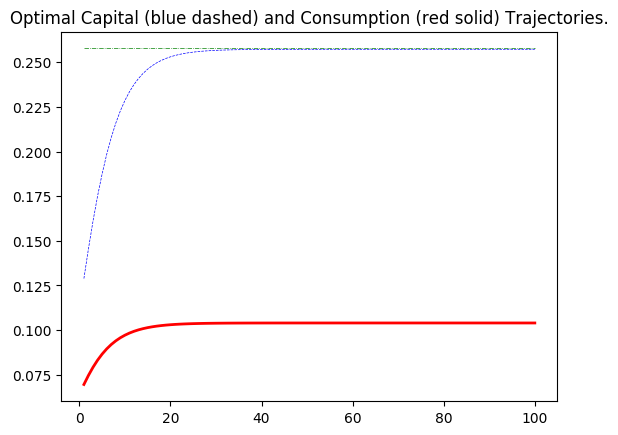

Validate the solution: Does the final capital value of 0.25726148642513164 arrive at the analytically derived capital steady state of 0.2577148681640624?


In [79]:
# Simulate using solved policy function

# Horizon of simulation
horizon = 100

# Initialize capital and consumption vectors
k = zeros(horizon+1)
c = zeros(horizon)

# Initial capital value
k[1] = steady_capital/2

# Simulate
for t = 1:horizon
    c_out, c_eval = funeval(space[:c],space,[k[t]])
    c[t] = c_out[1]
    k[t+1] = k[t]^alpha-c[t]
end

# Plot
plot(1:horizon, c, color="red", linewidth=2.0)
plot(1:horizon, k[1:end-1], color="blue", linewidth=0.5, linestyle="--")
plot(1:horizon, steady_capital*ones(horizon), color="green", linewidth=0.5, linestyle="-.")
title("Optimal Capital (blue dashed) and Consumption (red solid) Trajectories.")
println("Validate the solution: Does the final capital value of $(k[end]) arrive at the analytically derived capital steady state of $(steady_capital)?")

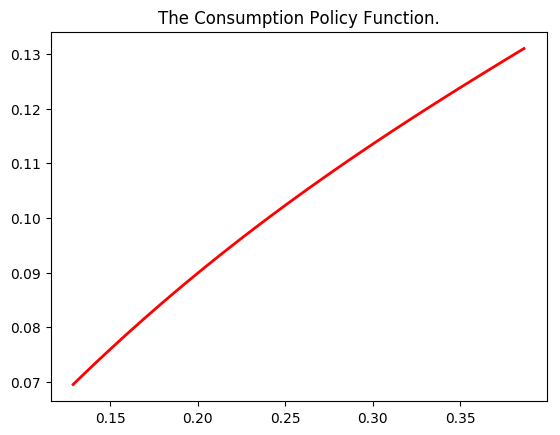

PyObject <matplotlib.text.Text object at 0x7f7c86a88390>

In [80]:
# Plot optimal policy function

# Initialize consumption array
c = zeros(horizon)

# Put a fine grid over the capital domain
capital_levels = linspace(lower_bound,upper_bound,100)

# Compute optimal consumption at all capital grid points
for t = 1:100
    c_out, c_eval = funeval(space[:c],space,[capital_levels[t]])
    c[t] = c_out[1]
end

# Plot policy function
plot(capital_levels, c, color="red", linewidth=2.0)
title("The Consumption Policy Function.")

### Time Iteration

In [81]:
# Model parameters, only changes to TI from VFI
damp = 0.7 # Damping
tol = 1e-4 # Tolerance
error = 1e10 # Initial error

1.0e10

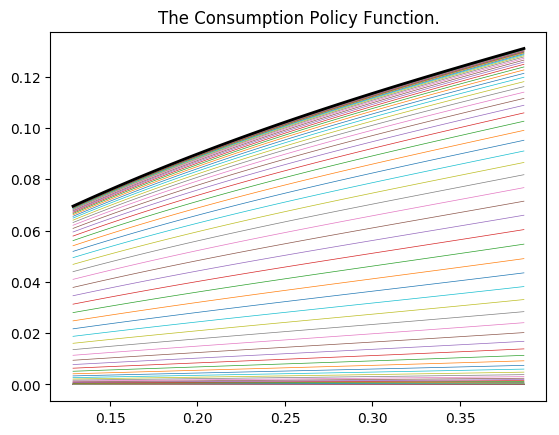

PyObject <matplotlib.text.Text object at 0x7f7c869e1f10>

In [82]:
## TIME ITERATION

# Initial coefficient vector
space[:c] = 0.*ones(space[:num_nodes])

# Initialize consumption array
cons = Array{Float64}(space[:num_nodes])

while error > tol
    
    # Plot optimal policy function

    # Initialize consumption array
    c = zeros(100)

    # Put a fine grid over the capital domain
    capital_levels = linspace(lower_bound,upper_bound,100)

    # Compute optimal consumption at all capital grid points
    for t = 1:100
        c_out, c_eval = funeval(space[:c],space,[capital_levels[t]])
        c[t] = c_out[1]
    end

    # Plot policy function
    plot(capital_levels, c, linewidth=0.5)
    title("The Consumption Policy Function.")
    
    # Compute next period's consumption from the Euler equation
    for i = 1:space[:num_nodes]

      capital = s[i]
      
      # Time iteration Euler equation
      # u'(c_t(k_t)) = beta*u'(c_t+1(c_t(k_t),k_t))*F'(k_t+1(c(k_t),k_t))
      # k_t+1 = F(k_t) - c_t
      function euler(cons_guess::Float64)
      
          # Next period's capital given current capital and consumption
          capital_next = capital^alpha-cons_guess
          
          # Next period's consumption given current capital and consumption
          cons_next, eval = funeval(space[:c],space,[capital_next])
          cons_next = max(1e-10,cons_next)
          # Next period's consumption from Euler equation
          euler_error = cons_guess^(-gamma)./(beta*cons_next^(-gamma)*alpha*(capital_next).^(alpha-1))-1
          return euler_error[1]
      end
        
        # Try bracketing search, otherwise do initial guess search
        try 
            cons[i] = fzero(euler,0.,capital)
        catch
            cons[i] = fzero(euler,capital/2)
        end
        
    end

    # New coefficients on approximant, damp the update
    c_next = damp*(Binv*cons) + (1-damp)*space[:c]

    # Relative change in coefficients at collocation nodes
    error = maximum(abs.((c_next-space[:c])./c_next))

    # Update coefficients
    space[:c] = c_next

    # Display error
    #println("Maximum Error of $(error).")
end

# Plot optimal policy function

# Initialize consumption array
c = zeros(100)

# Put a fine grid over the capital domain
capital_levels = linspace(lower_bound,upper_bound,100)

# Compute optimal consumption at all capital grid points
for t = 1:100
    c_out, c_eval = funeval(space[:c],space,[capital_levels[t]])
    c[t] = c_out[1]
end

# Plot policy function
plot(capital_levels, c, linewidth=2.0, color="black")
title("The Consumption Policy Function.")

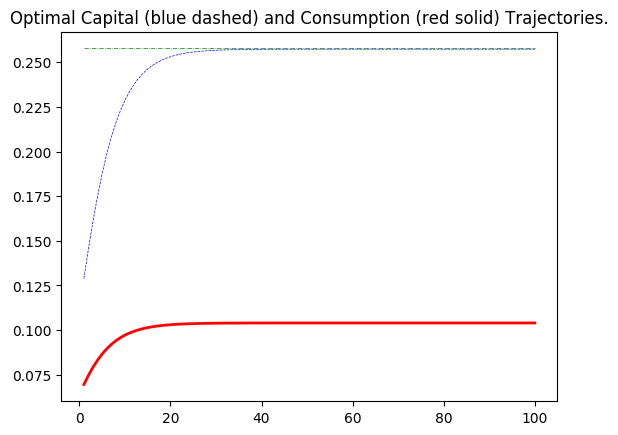

Validate the solution: Does the final capital value of 0.2573204844287994 arrive at the analytically derived capital steady state of 0.2577148681640624?


In [83]:
# Simulate using solved policy function

# Horizon of simulation
horizon = 100

# Initialize capital and consumption vectors
k = zeros(horizon+1)
c = zeros(horizon)

# Initial capital value
k[1] = steady_capital/2

# Simulate
for t = 1:horizon
    c_out, c_eval = funeval(space[:c],space,[k[t]])
    c[t] = c_out[1]
    k[t+1] = k[t]^alpha-c[t]
end

# Plot
plot(1:horizon, c, color="red", linewidth=2.0)
plot(1:horizon, k[1:end-1], color="blue", linewidth=0.5, linestyle="--")
plot(1:horizon, steady_capital*ones(horizon), color="green", linewidth=0.5, linestyle="-.")
title("Optimal Capital (blue dashed) and Consumption (red solid) Trajectories.")
println("Validate the solution: Does the final capital value of $(k[end]) arrive at the analytically derived capital steady state of $(steady_capital)?")

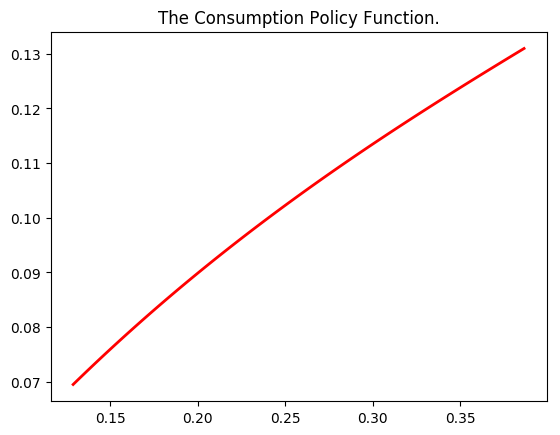

PyObject <matplotlib.text.Text object at 0x7f7c865c0d10>

In [84]:
# Plot optimal policy function

# Initialize consumption array
c = zeros(horizon)

# Put a fine grid over the capital domain
capital_levels = linspace(lower_bound,upper_bound,100)

# Compute optimal consumption at all capital grid points
for t = 1:100
    c_out, c_eval = funeval(space[:c],space,[capital_levels[t]])
    c[t] = c_out[1]
end

# Plot policy function
plot(capital_levels, c, color="red", linewidth=2.0)
title("The Consumption Policy Function.")

## Stability

Play around with the damping parameter and the number of collocation nodes. How stable are the different approaches as you increase the number of nodes? Does more damping help the problem? Plot the value/policy functions as you iterate closer to the solution in cases where the algorithm isn't stable. Does anything about the shape of the function appear strange?